#### Libraries and dependencies

In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.signal import butter
from copy import deepcopy
from scipy.signal import filtfilt
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

In [2]:
probes = cache.get_probe_table() # type: ignore
valid_lfp = probes[probes['has_lfp_data']]
print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9602209944751381


In [3]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
lfp = session.get_lfp(1064735073)
#lfp

#### Tutorial

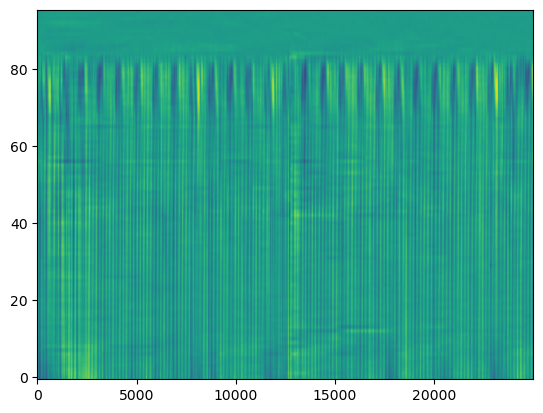

In [5]:
lfp_slice = lfp.sel(time=slice(100,120))
plt.imshow(lfp_slice.T, aspect='auto',origin='lower', cmap='viridis')

In [19]:
stim_presentations = session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
presentation_times = flashes.start_time.values
presentation_ids = flashes.index.values

In [20]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [26]:
aligned_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), presentation_times, presentation_ids)

Text(-0.4, 3570, 'brain surface')

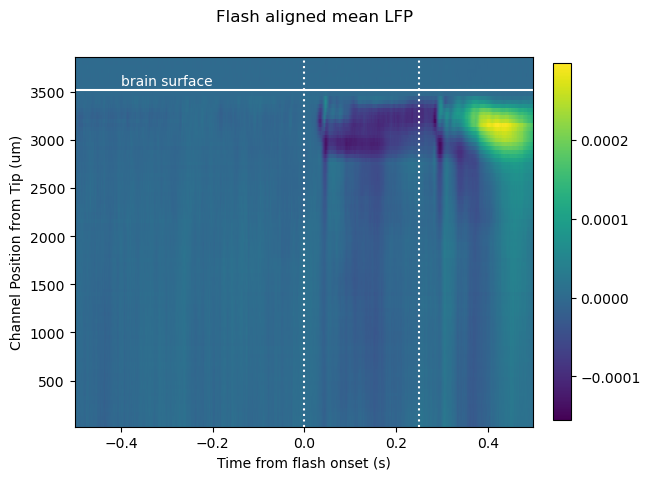

In [27]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

#### Filtering

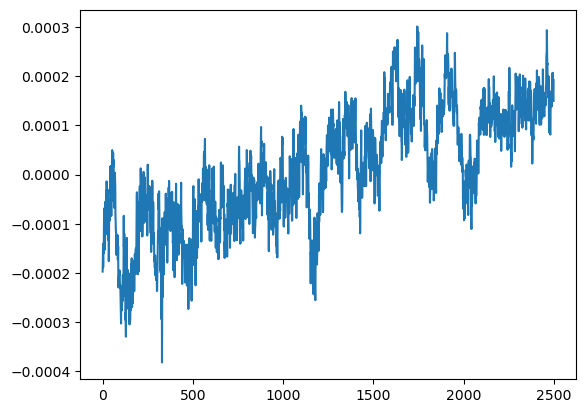

In [24]:
lfp_slice = lfp.sel(time=slice(100,102))
lfp_copy = deepcopy(lfp_slice)
b,a = butter(N=3, Wn=[3, 8], fs=1500, btype='bandpass', output='ba')
single = lfp_copy.T[0]
plt.plot(single);

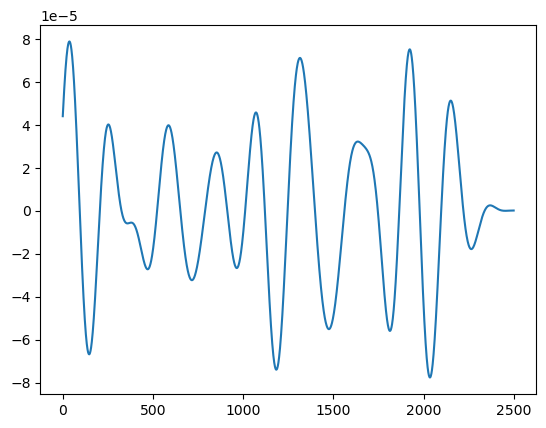

In [25]:
y = filtfilt(b, a, single)
plt.plot(y)

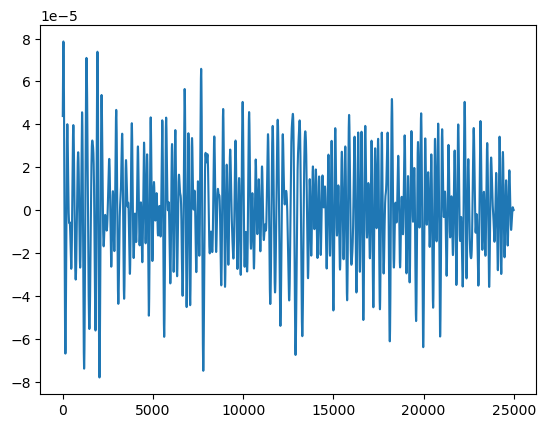